In [1]:
import _pickle as cPickle
import pickle
import pandas as pd
import os
import random
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA as sklearnPCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn import cluster as Kcluster, metrics as Met ,preprocessing as preprocessing
import numpy as np
import pylab as pl
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import argparse
# from tabulate import tabulate

## Read the data, flatten and shuffle the data and labels

In [2]:
def load_data(data_path,label_path):
    global sample_set
    global sample_data
    # Get the sample identifier(accession). Optionally equally subsample from each class label
    sample_set = pd.read_csv(label_path, sep=',', error_bad_lines=False)
    sample_set['combined']=sample_set['population']+sample_set['sequencing_center'].astype(str)
    #Equally Subsample from each of the classses
    # for lab in labels:
    #     SAMPLES_FILETERED = SAMPLES[SAMPLES.label == lab].sample(n=50)
    #     sample_set =sample_set.append(SAMPLES_FILETERED,ignore_index=False)
    sample_set_id = sample_set['accession']
    sample_data = pd.DataFrame()
    root = data_path
    for sampleid in sample_set_id:
        try:
            #ambig_info_df = pd.read_csv(root+"\\"+sampleid+ '\\bias\\aux_info\\ambig_info.tsv',sep='\t',error_bad_lines=False)
            quantified_data = pd.read_csv(root+"//"+sampleid+"//bias//quant2.sf",sep='\t',error_bad_lines=False)
            #quantified_data = pd.DataFrame(pd.concat([quantified_data, ambig_info_df], axis=1).set_index('Name').stack()).transpose()
            quantified_data = pd.DataFrame(quantified_data.set_index('Name').stack()).transpose()
            sample_data = sample_data.append(quantified_data)
        except KeyboardInterrupt:
            break 
    #     sample_data.drop('Length', axis=1, level=1, inplace=True)
    #     pickle.dump(sample_data, open("data_ambig_300.pkl", 'wb'))
    #Shuffle the data and the labels
    shufflelist = list(range(sample_data.shape[0]))
    random.shuffle(shufflelist)
    sample_data=sample_data.iloc[shufflelist,:]
    sample_set=sample_set.iloc[shufflelist,:]

In [3]:
class predictorROC:   
    #Yreal is the real outcome value, Yscore is the caluclated value
    #threshold is the threshold value to calculate the specificity and sensitivity  
    def draw_roc(self, Yreal, Yscore):
        fpr = []
        tpr = []
        roc_auc = []
        fpr, tpr, _ = roc_curve(Yreal, Yscore)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

# Dimensionality Reduction Using PCA

In [4]:
def get_eigenvalues(data):
    U, V, W = np.linalg.svd(data, full_matrices=False)
    return U,V

def perf_pca(data):
    #U, V, W = np.linalg.svd(data, full_matrices=False)
    #newV = [x for x in V if x >= 1]
    # find the number of principal components.
    # select the components with eigenvalue greater than 1.
    #dim = len(newV)
#     sk_pca = sklearnPCA(n_components=mle)
    sk_pca = sklearnPCA()
    pca = sk_pca.fit_transform(data)
    return pca

In [5]:
def calc_pca():
    #Unable to do normalization for large inputs due to memory issues.
    # Normalize the data
    # sample_norm_data = preprocessing.scale(np.array(sample_data))
    # Compute the correlation matrix
    # sample_corr_data = np.corrcoef(sample_norm_data, rowvar=False)
    #pca_sample = perf_pca(sample_corr_data)
    pca=perf_pca(sample_data)
    # pca = pickle.load(open("pca_ambig_250.pkl",'rb'))
    pca.shape

## Preprocessing and Classifier functions

In [6]:
def perf_logistic_regression(xtr, ytr,xtest):
    logm = LogisticRegression()
    logm.fit(xtr,ytr)
    return logm.predict(xtest)

In [7]:
def perf_random_forest(xtr,ytr,xtest):
    rf = RandomForestClassifier(n_estimators=250)
    rf.fit(xtr, ytr)
    return rf.predict(xtest)

In [8]:
def perf_neural_network(xtr,ytr,xtest):
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
    perf_preprocessing(xtr,xtest)
    clf.fit(xtr,ytr)
    return clf.predict(xtest)

In [9]:
def perf_preprocessing(xtr,xtest):
    scaler = StandardScaler()
    # Fit only to the training data
    scaler.fit(xtr)
    StandardScaler(copy=True, with_mean=True, with_std=True)
    # Now apply the transformations to the data:
    xtr = scaler.transform(xtr)
    xtest = scaler.transform(xtest)
    return xtr,xtest

## Feature Selection using ExtraTreeClassifier

In [10]:
def perf_ftr_selection(data,label,plotDistr):
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=0)
    forest.fit(data, label)
    index = data.shape[1]
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]    
    for f in range(data.shape[1]):
#       print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
        if importances[indices[f]] == 0:
            index = f-1
            break
    #Plot the feature importance distribution. This plot how many features are important among all the features        
    if plotDistr:
        pl.figure()
        pl.title("Feature importances")
        for tree in forest.estimators_:
            pl.plot(range(index+1000), tree.feature_importances_[indices[:index+1000]], "r")

        pl.plot(range(index+1000), importances[indices[:index+1000]], "b")
        pl.show()
    
    return indices[:index]

## Perform Cross Validation 

In [11]:
def perf_cross_validation(X,y,nfolds):
    kf = KFold(n_splits = nfolds)
    kf.get_n_splits(X)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        #Select the best features for the current fold
        ftr_indices = perf_ftr_selection(X_train,y_train,False)
        train_data=X_train.iloc[:,ftr_indices]
        test_data = X_test.iloc[:,ftr_indices]
        
        #Print the classification report for each fold
        print ("Train data shape", train_data.shape , "label shape",y_train.shape, "test shape", test_data.shape)
        predictions = perf_random_forest(train_data,y_train,test_data)
        print (classification_report(y_test,predictions))

In [12]:
def prnt_cross_val_results():
    label_type = ['population','sequencing_center','combined']
    for label in label_type:
        print ("Performing cross validation for label : " , label)
        perf_cross_validation(sample_data,sample_set[label],3)

## Create the model dump for each classifier

In [13]:
def create_model_dump():
    label_type = ['population','sequencing_center','combined']
    for label in label_type:
        indices = perf_ftr_selection(sample_data,sample_set[label],True)
        reduced_data= sample_data.iloc[:,indices]
        rf = RandomForestClassifier(n_estimators=250)
        rf.fit(reduced_data,sample_set[label])
        pickle.dump((indices,rf), open("model_"+label+".pkl", 'wb'))

In [14]:
#function to parse the input argument
def arg_parser():
    parser = argparse.ArgumentParser('PhenotypicPredictor.py',add_help = True)
    parser.add_argument("-m" , metavar = "<Path to model dump>")
    parser.add_argument("-t" , metavar = "<Path to test sample>")
    parser.add_argument("-l" , metavar = "<Path to test label file>")
    args = parser.parse_args()
    return args.m ,args.t, args.l

In [15]:
def main():
    model_path, test_data_path, test_label_path = arg_parser()
#     model_path, test_data_path, test_label_path = "/Users/shilpageorge/Desktop/Fall'17/CB/","/Users/shilpageorge/Desktop/Fall'17/CB/test","/Users/shilpageorge/Desktop/Fall'17/CB/p1_train_pop_lab_test_label.csv"
    population_indices,model_population = pickle.load(open(model_path.rstrip("/")+"/model_population.pkl",'rb'))
    combined_indices,model_combined = pickle.load(open(model_path.rstrip("/")+"/model_combined.pkl",'rb'))
    seq_indices,model_seq = pickle.load(open(model_path.rstrip("/")+"/model_sequencing_center.pkl",'rb'))
    #call load_data. The data will be loaded to the global dataframe sample_data
    #labels will be loaded to the global dataframe sample_set
    load_data(test_data_path.rstrip("/"),test_label_path.rstrip("/"))
    
    #Compute the predictions using the model dump for each classifier
    population_predictions = model_population.predict(sample_data.iloc[:,population_indices])
    seq_predictions = model_seq.predict(sample_data.iloc[:,seq_indices])
    combined_predictions = model_combined.predict(sample_data.iloc[:,combined_indices])
    
    
    #Print the classification report for each classifier
    print ( "F1 Score and Accuracy for Classifier label - Population \n")
    print (classification_report(sample_set['population'],population_predictions))
    print ( "F1 Score and Accuracy for Classifier label - Sequencing Centre \n")
    print (classification_report(sample_set['sequencing_center'],seq_predictions))
    print ( "F1 Score and Accuracy for Classifier label - Joint \n")
    print (classification_report(sample_set['combined'],combined_predictions))

In [16]:
#Training mode. Load the training data, perform cross validation 
load_data(r"/Users/shilpageorge/Desktop/Fall-17/CB/train",r"/Users/shilpageorge/Desktop/Fall-17/CB/p1_train_pop_lab.csv")
prnt_cross_val_results()

Performing cross validation for label :  population
Train data shape (246, 15990) label shape (246,) test shape (123, 15990)
             precision    recall  f1-score   support

        CEU       0.80      1.00      0.89        16
        FIN       0.80      0.86      0.83        28
        GBR       0.81      0.81      0.81        31
        TSI       0.77      0.59      0.67        29
        YRI       0.95      1.00      0.97        19

avg / total       0.82      0.82      0.81       123

Train data shape (246, 15841) label shape (246,) test shape (123, 15841)
             precision    recall  f1-score   support

        CEU       0.83      1.00      0.91        24
        FIN       0.86      0.83      0.85        30
        GBR       0.94      0.81      0.87        21
        TSI       0.70      0.67      0.68        21
        YRI       0.96      0.96      0.96        27

avg / total       0.86      0.86      0.86       123

Train data shape (246, 16079) label shape (246,) test 

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


             precision    recall  f1-score   support

       CEU1       0.71      1.00      0.83         5
       CEU2       0.25      0.67      0.36         3
       CEU3       0.50      0.50      0.50         2
       CEU4       0.67      1.00      0.80         2
       CEU5       0.00      0.00      0.00         1
       CEU6       0.00      0.00      0.00         2
       CEU7       0.14      1.00      0.25         1
       FIN1       1.00      0.60      0.75        10
       FIN2       0.33      0.83      0.48         6
       FIN3       1.00      0.67      0.80         3
       FIN4       0.44      0.80      0.57         5
       FIN5       0.17      0.50      0.25         2
       FIN6       0.00      0.00      0.00         0
       FIN7       0.00      0.00      0.00         2
       GBR1       0.29      1.00      0.44         2
       GBR2       0.33      0.11      0.17         9
       GBR3       0.33      0.33      0.33         3
       GBR4       0.00      0.00      0.00   

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


             precision    recall  f1-score   support

       CEU1       0.86      1.00      0.92         6
       CEU2       0.40      1.00      0.57         2
       CEU3       0.50      0.20      0.29         5
       CEU4       0.33      0.25      0.29         4
       CEU5       0.00      0.00      0.00         1
       CEU6       0.00      0.00      0.00         2
       CEU7       0.50      0.75      0.60         4
       FIN1       0.64      1.00      0.78         7
       FIN2       1.00      0.80      0.89         5
       FIN3       0.20      0.75      0.32         4
       FIN4       1.00      0.12      0.22         8
       FIN5       0.50      0.67      0.57         3
       FIN6       0.00      0.00      0.00         1
       FIN7       0.00      0.00      0.00         2
       GBR1       1.00      0.17      0.29         6
       GBR2       0.25      1.00      0.40         2
       GBR3       0.00      0.00      0.00         6
       GBR4       0.00      0.00      0.00   

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


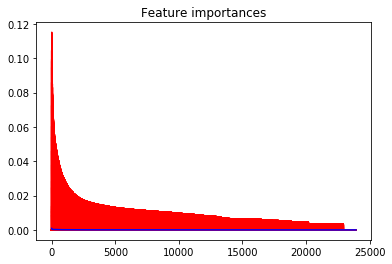

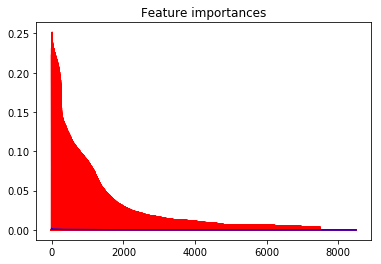

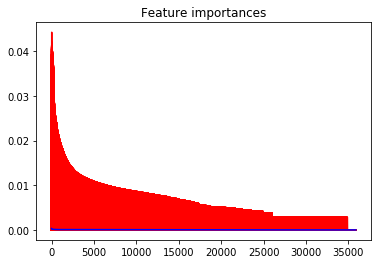

In [17]:
#Optionally create the model dump fo r this training 
create_model_dump()